In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from scipy.constants import epsilon_0, hbar, k


import sys

sys.path.append('../scripts')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from elements import *

import measurement as me

### One optical mode, coupled to 2 mechanical modes, driven by 2 drives

In [260]:
omega_cav = 5e9*np.pi*2
kappa_0 = 0.3e6*np.pi*2

omega_m1 = 5e6*np.pi*2
gamma_m1 = 100*np.pi*2
g_01 = 200*np.pi*2

omega_m2 = 7e6*np.pi*2
gamma_m2 = 100*np.pi*2
g_02 = 200*np.pi*2

P_in1 = 8e-1
Delta1 = -(omega_m1)
omega_drive1 = omega_cav + Delta1
T_drive1 = 1
kappa_ex1 = 0.4e6*np.pi*2

P_in2 = 8e-1
Delta2 = -omega_m2
omega_drive2 = omega_cav + Delta2
T_drive2 = 10e-3
kappa_ex2 = 0.4e6*np.pi*2

In [261]:
def eqs(p):
    N1, N2 = p
    A1 = (kappa_0**2/4 + (omega_cav - omega_cont1 - (N1+0*N2)*(g_01/omega_m1 + g_02/omega_m2))**2)*N1 - kappa_ex1 * P_in1
    A2 = (kappa_0**2/4 + (omega_cav - omega_cont2 - (N1+0*N2)*(g_01/omega_m1 + g_02/omega_m2))**2)*N2 - kappa_ex2 * P_in2
    return (A1,A2)

from scipy.optimize import fsolve

N1, N2 = fsolve(eqs, (100,0))
print(N1, N2)

2.035351455266732e-09 1.0389021732756693e-09


In [266]:
from DCnonlinearities import optomechanics



"""
***Solving nonlinear equations to calculate g1, g2 and omega_cav_new***
"""
omdir1 = optomechanics(P_in1, kappa_0, kappa_ex1, omega_cav, omega_drive1, omega_m1, g_01)
alpha1= omdir1['g'] / g_01
#omega_cav = omdir1['omega_c']

omdir2 = optomechanics(P_in2, kappa_0, kappa_ex2, omega_cav, omega_drive2, omega_m2, g_02)
alpha2= omdir2['g'] / g_02

#omega_cav = omdir2['omega_c']
#""";
"""g11 = alpha1 * g_01
g12 = alpha1 * g_02
g21 = alpha2 * g_01
g22 = alpha2 * g_02"""
g = [1e6]*4
g11, g12, g21, g22 = g
a1 = Mode('a1', omega_cav)
a2 = Mode('a2', omega_cav)
b1 = Mode('b1', omega_m1)
b2 = Mode('b2', omega_m2)

a1_in0 = Input('0', a1, kappa_0, kind = 'bath', bath_temp=10e-3)
a2_in0 = Input('0', a2, kappa_0, kind = 'bath', bath_temp=10e-3)
b1_in0 = Input('0', b1, gamma_m1, kind = 'bath', bath_temp=10e-3)
b2_in0 = Input('0', b2, gamma_m2, kind = 'bath', bath_temp=10e-3)

a1_drive1 = Input('ex', a1, kappa_ex1, kind = 'drive', omega_drive = omega_drive1, bath_temp = T_drive1)
a2_drive2 = Input('ex', a2, kappa_ex2, kind = 'drive', omega_drive = omega_drive2, bath_temp = T_drive2)

g_a1b1 = Coupling(a1, b1, g11 * np.array([1,0,0,0]))
g_a1b2 = Coupling(a1, b2, 0*g12 * np.array([1,0,0,0]))
g_a2b1 = Coupling(a2, b1, 0*g21 * np.array([1,0,0,0]))
g_a2b2 = Coupling(a2, b2, g22 * np.array([1,0,0,0]))


sys_om = System([a1, a2, b1, b2], [a1_in0, a2_in0, b1_in0, b2_in0, a1_drive1,a2_drive2], [g_a1b1, g_a1b2, g_a2b1, g_a2b2])

#print ('Cooperativity C1: ',4*g1**2/a1.kappa/gamma_m1,'C2: ',4*g2**2/a2.kappa/gamma_m2)


<IPython.core.display.Javascript object>


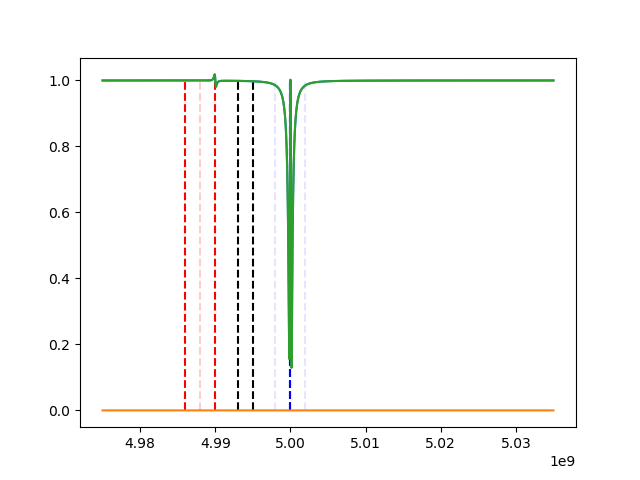

In [267]:
a1_out = Output(sys_om, a1_drive1)

omegas = np.linspace(omega_cav - 5* omega_m1, omega_cav +  5*omega_m2, 20000)
omegas_new11, S11 = me.linear_response(omegas, sys_om, a1_out, a1_drive1, plot = 0)
omegas_new12, S12 = me.linear_response(omegas, sys_om, a1_out, a2_drive2, plot = 0)

plt.figure()
plt.plot(omegas/2/np.pi, abs(S11),omegas/2/np.pi, abs(S12))
plt.plot(omegas/2/np.pi, abs(S11+S12))

plt.vlines([omega_drive1/2/np.pi, omega_drive2/2/np.pi], 0 ,1, linestyles = 'dashed')
plt.vlines([(-omega_m1+omega_drive1)/2/np.pi, (omega_drive1+omega_m1)/2/np.pi], 0 ,1, linestyles = 'dashed', colors = ['red','blue'])
plt.vlines([(-omega_m2+omega_drive2)/2/np.pi, (omega_drive2+omega_m2)/2/np.pi], 0 ,1, linestyles = 'dashed', colors = ['red','blue'])

plt.vlines([(-omega_m1+omega_drive2)/2/np.pi, (omega_drive2+omega_m1)/2/np.pi], 0 ,1, linestyles = 'dashed', colors = ['red','blue'], alpha = 0.1)
plt.vlines([(-omega_m2+omega_drive1)/2/np.pi, (omega_drive1+omega_m2)/2/np.pi], 0 ,1, linestyles = 'dashed', colors = ['red','blue'], alpha = 0.1)



<IPython.core.display.Javascript object>


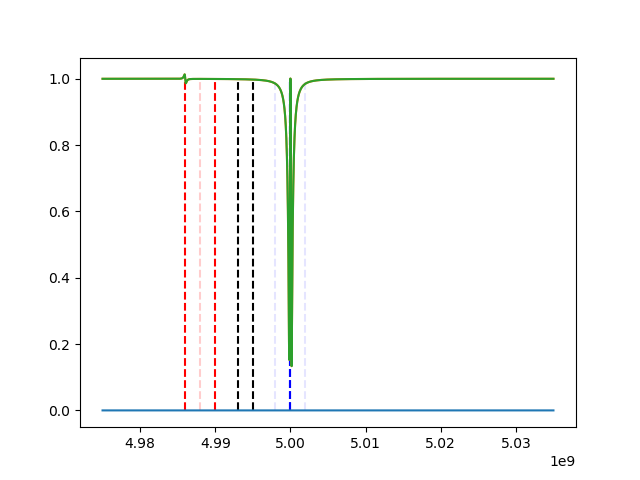

In [268]:
a2_out = Output(sys_om, a2_drive2)

omegas = np.linspace(omega_cav - 5* omega_m1, omega_cav +  5*omega_m2, 20000)
omegas_new21, S21 = me.linear_response(omegas, sys_om, a2_out, a1_drive1, plot = 0)
omegas_new22, S22 = me.linear_response(omegas, sys_om, a2_out, a2_drive2, plot = 0)

plt.figure()
plt.plot(omegas/2/np.pi, abs(S21), omegas/2/np.pi, abs(S22))
plt.plot(omegas/2/np.pi, abs(S22+S21))
plt.vlines([omega_drive1/2/np.pi, omega_drive2/2/np.pi], 0 ,1, linestyles = 'dashed')


plt.vlines([(-omega_m1+omega_drive1)/2/np.pi, (omega_drive1+omega_m1)/2/np.pi], 0 ,1, linestyles = 'dashed', colors = ['red','blue'])
plt.vlines([(-omega_m2+omega_drive2)/2/np.pi, (omega_drive2+omega_m2)/2/np.pi], 0 ,1, linestyles = 'dashed', colors = ['red','blue'])

plt.vlines([(-omega_m1+omega_drive2)/2/np.pi, (omega_drive2+omega_m1)/2/np.pi], 0 ,1, linestyles = 'dashed', colors = ['red','blue'], alpha = 0.1)
plt.vlines([(-omega_m2+omega_drive1)/2/np.pi, (omega_drive1+omega_m2)/2/np.pi], 0 ,1, linestyles = 'dashed', colors = ['red','blue'], alpha = 0.1)



<IPython.core.display.Javascript object>


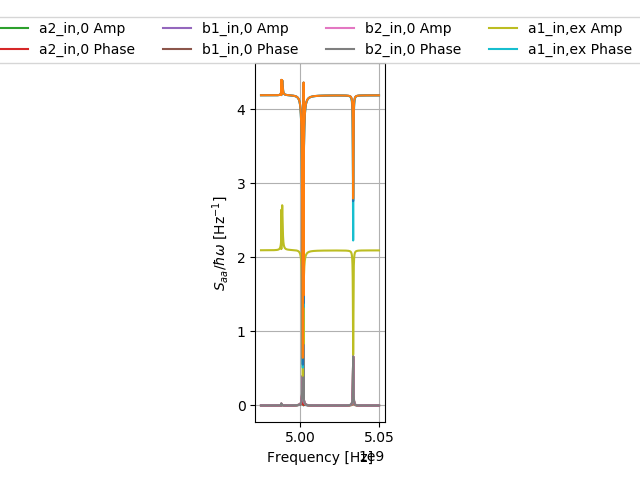

<IPython.core.display.Javascript object>


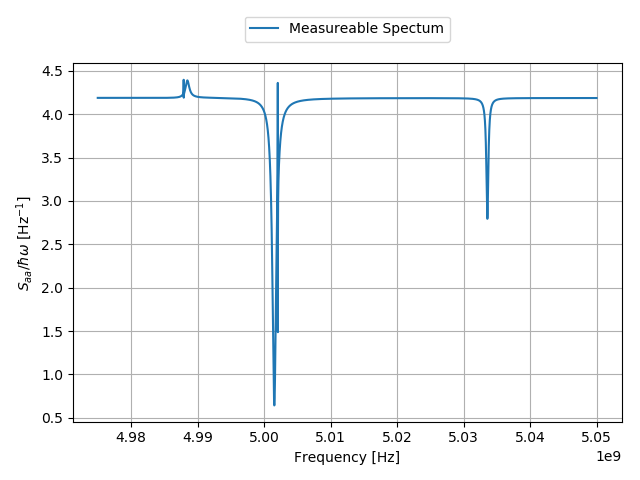

In [231]:
spec = me.spectrum(omegas,me.PowerMeasurement(a1_out), components=1, plot=1)

<IPython.core.display.Javascript object>


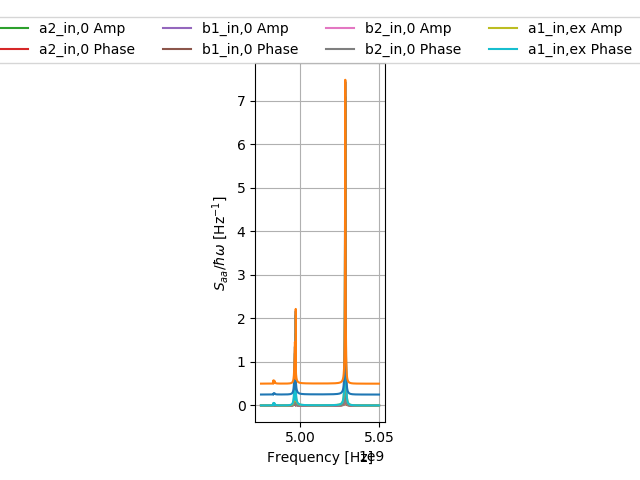

<IPython.core.display.Javascript object>


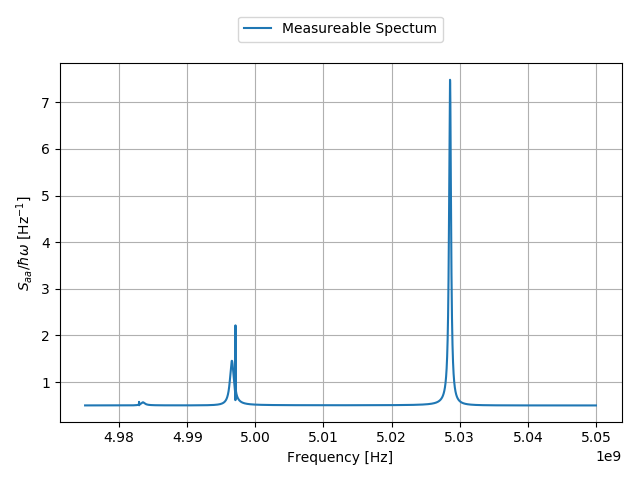

In [232]:
spec = me.spectrum(omegas,me.PowerMeasurement(a2_out), components=1, plot=1)

In [228]:
"""def eqs(a, b = [], omega_c, kappa_0, omega_drives = [], g_0s = [], kappa_exts = [], P_ins = [], omega_ms = [], gamma_ms = []):
    myi = np.array([[0,-1],[1,0]])
    OmegaShift = 0 
    A = np.zeros(length(omega_drives))
    B = np.zeros(length(omega_ms))
    for k in enumerate(g_0s):
        OmegaShift += 2 * g_0s[k] * b[2*k]
    for j in enumerate(omega_drives):
        a.dot(a)
    A = -omega_drive * myi.dot(a) + (omega_drive * myi + np.eye(2)*kappa_0/2).dot(a) + OmegaShift * myi.dot(a)
    B = (omega_ms * myi + np.eye(2)*gamma_ms/2).dot(a)
    """;